In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# ML-related
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Default Python
import random
from pathlib import Path

# Other Libraries
from PIL import Image
from tqdm import tqdm

In [6]:
root_dir = Path('Stanford_cars_dataset')
cars_test = root_dir / 'cars_test' / 'cars_test'
cars_train = root_dir / 'cars_train' / 'cars_train'

training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)

root_dir = Path("Standford_cars_dataset_meta")
cars_annos_train = root_dir / "devkit" / "cars_train_annos.mat"
cars_annos_test = root_dir / "cars_test_annos_withlabels (1).mat"

cars_meta_mat = loadmat(root_dir / "devkit" / "cars_meta.mat")

cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test)

class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]

sample1 = cars_annos_train_mat['annotations'][0][0]
sample1_path, sample1_class = sample1[-1][0], sample1[-2][0][0] - 1

device = "cuda" if torch.cuda.is_available() else "cpu"

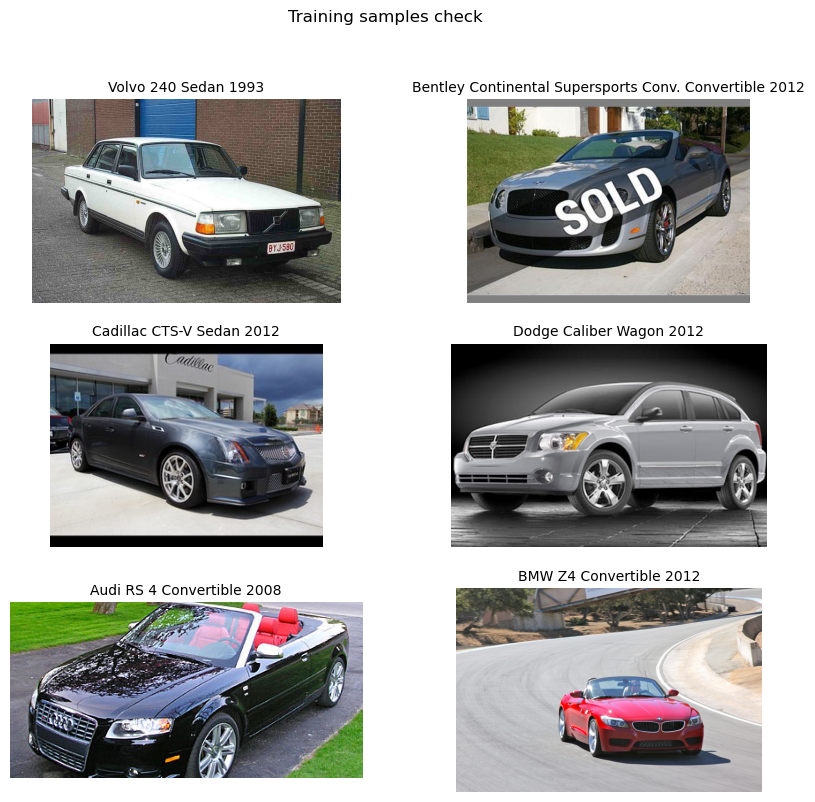

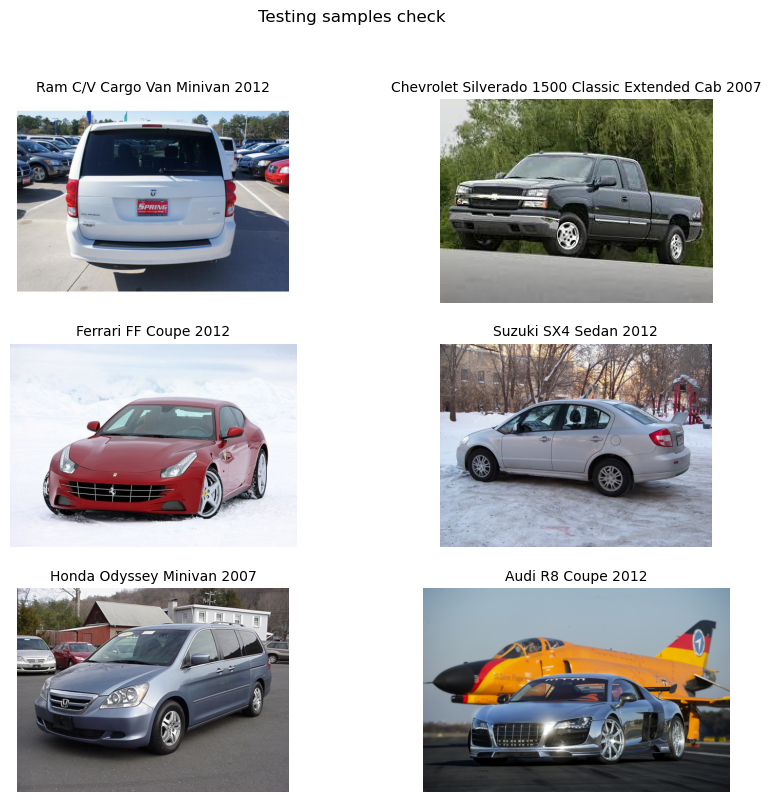

In [7]:
w, h = 2, 3
fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h))
fig.suptitle('Training samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_train_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_train, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

fig, axes_list = plt.subplots(h, w, figsize=(5*w, 3*h))
fig.suptitle('Testing samples check')

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        random_index = random.randint(0, 500)
        random_sample = cars_annos_test_mat['annotations'][0][random_index]
        sample_path, sample_class = random_sample[-1][0], random_sample[-2][0][0] - 1
        im = Image.open(os.path.join(cars_test, sample_path))
        ax.imshow(im)
        ax.set_title(class_names[sample_class], fontdict={"fontsize": 10})

In [8]:
# Looking good so far. Now we're ready to define our model, transformations, datasets, dataloaders, and training/testing loop

googlenet_weights = torchvision.models.GoogLeNet_Weights.DEFAULT
googlenet = torchvision.models.googlenet(weights=googlenet_weights).to(device)
googlenet_transforms = googlenet_weights.transforms()

for param in googlenet.parameters():
    param.requires_grad = False

googlenet.fc = nn.Sequential(
    nn.Linear(in_features=1024, out_features=len(class_names), bias=True)
).to(device)

In [9]:
# Datasets - create custom dataset and a dictionary which relates image path to label

training_image_label_dictionary, testing_image_label_dictionary = {}, {}
labels=np.zeros(196)

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dictionary[image] = label
    labels[label]+=1

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dictionary[image] = label

# Using these data structures, we'll be able to return an image and a label easily in our custom dataset as we'll see in a bit
print(len(training_image_label_dictionary), len(testing_image_label_dictionary)) \
    # The classes seems to be balanced .. not 100% but n clear skewness
print(labels)

8144 8041
[45. 32. 43. 42. 41. 45. 39. 45. 41. 33. 38. 37. 41. 43. 43. 44. 41. 43.
 41. 46. 42. 43. 40. 45. 40. 34. 36. 41. 43. 42. 44. 42. 42. 45. 41. 41.
 39. 41. 37. 39. 36. 35. 46. 45. 33. 44. 35. 43. 38. 42. 43. 41. 45. 40.
 40. 47. 38. 44. 45. 37. 43. 37. 44. 30. 45. 42. 39. 40. 38. 43. 35. 45.
 45. 44. 44. 44. 41. 38. 49. 43. 45. 45. 41. 42. 44. 43. 44. 40. 44. 41.
 39. 40. 39. 44. 46. 41. 42. 46. 28. 34. 42. 39. 40. 43. 44. 42. 45. 44.
 45. 43. 42. 46. 43. 45. 45. 38. 43. 42. 68. 43. 45. 40. 45. 39. 44. 42.
 41. 39. 39. 41. 42. 44. 42. 34. 42. 24. 44. 40. 43. 42. 34. 33. 40. 47.
 44. 43. 45. 45. 43. 36. 44. 36. 45. 43. 43. 39. 37. 29. 36. 44. 48. 46.
 37. 44. 45. 41. 48. 42. 39. 44. 46. 44. 44. 41. 31. 39. 44. 42. 45. 43.
 38. 46. 42. 41. 39. 39. 44. 44. 41. 43. 46. 43. 42. 46. 43. 40.]


In [13]:
class StanfordCarsCustomDataset(Dataset):
    def __init__(self, directory, image_label_dict, transforms):
        super().__init__()

        self.images = [os.path.join(directory, f) for f in os.listdir(directory)]
        self.transforms = transforms
        self.image_label_dict = image_label_dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Get image
        image = self.images[index]
        img_pil = Image.open(image).convert('RGB')
        img_trans = self.transforms(img_pil)

        # Parse out the label from cars_meta and cars_x_annos files
        image_stem = image.split("\\")[-1]
        img_label = self.image_label_dict[image_stem]

        return img_trans, img_label

In [14]:
train_dset = StanfordCarsCustomDataset(cars_train, training_image_label_dictionary, googlenet_transforms)
test_dset = StanfordCarsCustomDataset(cars_test, testing_image_label_dictionary, googlenet_transforms)

train_dloader = DataLoader(train_dset, batch_size=32, shuffle=False)
test_dloader = DataLoader(test_dset, batch_size=32,shuffle=False)

In [19]:
# Set up loss function, optmizer, and training/testing loops

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=googlenet.parameters(), lr=0.01)
epochs = 5

for epoch in tqdm(range(epochs)):
    googlenet.train()
    train_loss, train_acc = 0, 0

    # Training loop
    for (X, y) in train_dloader:
        X, y = X.to(device), y.to(device)

        y_logits = googlenet(X)
        y_pred_labels = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        train_acc += (y == y_pred_labels).sum().item() / len(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss /= len(train_dloader)
    train_acc /= len(train_dloader)

    # Testing loop
    googlenet.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for (A, b) in test_dloader:
            A, b = A.to(device), b.to(device)
            b_logits = googlenet(A)
            b_pred_labels = torch.softmax(b_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(b_logits, b).item()
            test_acc += (b == b_pred_labels).sum().item() / len(b)

    test_loss /= len(test_dloader)
    test_acc /= len(test_dloader)

    print(f"Epoch: {epoch} -> TrainLoss, TrainAcc: {train_loss}, {train_acc} && TestLoss, TestAcc: {test_loss}, {test_acc}")

  0%|          | 0/5 [00:01<?, ?it/s]


RuntimeError: expected scalar type Long but found Int